In [1]:
from google.colab import drive
#specify project directory in drive eg /content/drive/NLUProject
drive.mount('/content/drive')

#define necessary imports
import time
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.cluster import KMeans
from sklearn import preprocessing
from scipy import spatial

import gensim

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Define GRU model
class GRUModel(torch.nn.Module):

  def __init__(self, pretrainedEmbeddingWeights, gruHiddenDimensions, gruLayerNumber, outputClassNumber, paddingId):
    super(GRUModel, self).__init__()
    self.EmbeddingLayer = nn.Embedding.from_pretrained(pretrainedEmbeddingWeights, padding_idx = paddingId)
    self.EmbeddingDimensions = pretrainedEmbeddingWeights.size()[1]
    self.GRULayer = nn.GRU(self.EmbeddingDimensions, gruHiddenDimensions, batch_first=True)
    self.LinearLayer = nn.Linear(gruHiddenDimensions, outputClassNumber)
    self.nnSoftMax = nn.LogSoftmax()

  def forward(self, input):
    embeddedInput = self.EmbeddingLayer(input)
    gruOutput, finalHiddenStates = self.GRULayer(embeddedInput)
    gruOutsPooled = torch.mean(gruOutput, dim=1)
    linearOutput = self.LinearLayer(gruOutsPooled)

    softMaxOut = self.nnSoftMax(linearOutput)
    return softMaxOut

# Define LSTM model
class LSTMModel(torch.nn.Module):

  def __init__(self, pretrainedEmbeddingWeights, lstmHiddenDimensions, lstmLayerNumber, outputClassNumber, paddingId):
    super(LSTMModel, self).__init__()
    self.EmbeddingLayer = nn.Embedding.from_pretrained(pretrainedEmbeddingWeights, padding_idx = paddingId)
    self.EmbeddingDimensions = pretrainedEmbeddingWeights.size()[1]
    self.LSTMLayer = nn.LSTM(self.EmbeddingDimensions, lstmHiddenDimensions, batch_first=True)
    self.LinearLayer = nn.Linear(lstmHiddenDimensions, outputClassNumber)
    self.nnSoftMax = nn.LogSoftmax()

  def forward(self, input):
    embeddedInput = self.EmbeddingLayer(input)
    lstmOutput, (finalHiddenStates, finalCellStates) = self.LSTMLayer(embeddedInput)
    lstmOutsPooled = torch.mean(lstmOutput, dim=1)
    linearOutput = self.LinearLayer(lstmOutsPooled)
    softMaxOut = self.nnSoftMax(linearOutput)
    return softMaxOut

In [3]:
# Load gensim model back in
vector_model = gensim.models.KeyedVectors.load('drive/MyDrive/NLU Project/data/preProcessedEmbeddings/lyric-glove_vectors.kv')
padToken = '<pad>'
paddingID = vector_model.vocab[padToken].index

In [4]:
# load the GRU model back in
hiddnSize = 64
layers = 3

preTrainedEmbeddings = torch.from_numpy(vector_model.vectors)

# Import best model (GRU) as model
model = GRUModel(preTrainedEmbeddings, hiddnSize, layers, 14691, paddingID)
model.float()
model.load_state_dict(torch.load('drive/MyDrive/NLU Project/models/modelLyricsGRU'))

# Import LSTM model
modelLSTM = LSTMModel(preTrainedEmbeddings, hiddnSize, layers, 14691, paddingID)
modelLSTM.float()
modelLSTM.load_state_dict(torch.load('drive/MyDrive/NLU Project/models/modelLyricsLSTM'))

<All keys matched successfully>

In [5]:
class lyricDataset(Dataset):
    """lyric dataset."""

    def __init__(self, df):
        self.df = df
        self.maxLenForDF = self.getMaximumLengthSequence()
        self.padReturningItems(self.maxLenForDF)
        self.sendListToTensors()

    def padReturningItems(self, lengthToPadTo):
        for index, row in self.df.iterrows():
            paddingNeeded = (lengthToPadTo - len(row['lyric_tokens_reduced']))
            if(paddingNeeded > 0):
                padData = [paddingID] * paddingNeeded
                self.df.at[index, 'lyric_tokens_reduced'] = row['lyric_tokens_reduced'] + padData

    def sendListToTensors(self):
        for index, row in self.df.iterrows():
            self.df.at[index, "lyric_tokens_reduced"] = torch.tensor(row['lyric_tokens_reduced'], dtype=torch.int)
            self.df.at[index, "artist_label"] = torch.tensor(row['artist_label'], dtype=torch.int)

    def __len__(self):
        return self.df.shape[0]

    def getMaximumLengthSequence(self):
        dfColumnAsList = self.df['lyric_tokens_reduced'].tolist()
        listOfListLengths = [len(i) for i in dfColumnAsList]
        return max(listOfListLengths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        dfRowToReturn = self.df.iloc[idx]
        dictToReturn = {'input': dfRowToReturn['lyric_tokens_reduced'], 'label': dfRowToReturn['artist_label']}
        return dictToReturn


In [6]:
# Define accuracy function
def get_accuracy(dataloader, model):

  #model.eval()
  correctlyPredictedNum = 0
  acummulateLength = 0

  for i, data in enumerate(dataloader):
    modelOutputOnSampleBatch = model(data['input'])
    classPredictions = np.argmax(modelOutputOnSampleBatch.detach().numpy(), axis=1)
    correctBoolean = classPredictions == data['label'].detach().numpy()
    correctlyPredictedNum += np.sum(correctBoolean)
    acummulateLength+= data['input'].size(0)
  accuracyToReturn = correctlyPredictedNum / acummulateLength
  model.train()

  return accuracyToReturn

In [7]:
# Load datset
dataset = torch.load('drive/MyDrive/NLU Project/data/PyTorchDataset/LyricTest.pt')
unseen_artists = torch.load('drive/MyDrive/NLU Project/data/PyTorchDataset/UnseenArtistLyric.pt')
dataset.df = dataset.df.reset_index()
unseen_artists.df = unseen_artists.df.reset_index()

In [8]:
# Print list of artists
dataset.df.artist.unique()

array(['Lights', 'Ray J', 'Ryan Bingham', 'Joanie Sommers', 'Hefner',
       'Theory of a Deadman', 'Devo', 'The Outfield', 'Billy Ray Cyrus',
       'Jet', 'Rob Zombie', 'Robert Cray', 'Idina Menzel', 'Anastacia',
       'Merle Haggard', 'Ween', 'Built to Spill', 'Gluecifer',
       'Brian Wilson', 'Paul Carrack', 'Deer Tick', 'Project 86',
       "Gilbert O'Sullivan", 'We Are Scientists', 'Diana Ross',
       'Jake Owen', 'Indigo Girls', 'Fishbone', 'Tim McGraw',
       'Hunter Hayes', 'The Tragically Hip', 'Barenaked Ladies',
       'Alkaline Trio', 'Anthony Hamilton', 'The Stone Roses',
       'The Black Crowes', 'We Came as Romans', 'Meat Puppets', 'Saliva',
       'Prince', 'The Fall', 'BlackHawk', 'Barney', 'Iggy Pop',
       'Gipsy Kings', 'Simply Red', 'Done Again', 'The Tractors',
       'Hoodoo Gurus', 'Lester Young', 'Big Head Todd & the Monsters',
       'Bing Crosby', 'Lush', 'New Model Army', 'The Drifters',
       'Lifetime', 'The Countdown Kids', 'Clutch', 'Donovan',
 

Testing Accuracy

In [9]:
batchSize=64
test_dataloader = DataLoader(dataset, batch_size=batchSize*5)

In [10]:
print("LSTM Accuracy:", get_accuracy(test_dataloader, modelLSTM))
print("Lyric GRU Accuracy:", get_accuracy(test_dataloader, model))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


LSTM Accuracy: 0.15173333333333333


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Lyric GRU Accuracy: 0.2564533333333333


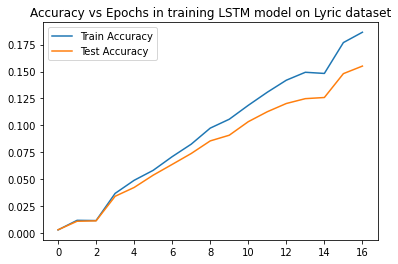

In [31]:
#load the lists generated during evaluation LSTM
with open('drive/MyDrive/NLU Project/evaluation-lists/LyricsLSTMTrainList', 'rb') as file:
     lstmTrainList = pickle.load(file)
with open('drive/MyDrive/NLU Project/evaluation-lists/LyricsLSTMTestList', 'rb') as file:
     lstmTestList = pickle.load(file)

#Plot training outputs on each model
epochRange1 = np.arange(len(lstmTestList))
epochRange2 = np.arange(len(lstmTestList))
plt.plot(epochRange1, lstmTrainList, label = "Train Accuracy")
plt.plot(epochRange1, lstmTestList, label = "Test Accuracy")
plt.title("Accuracy vs Epochs in training LSTM model on Lyric dataset")
plt.legend()
plt.show()


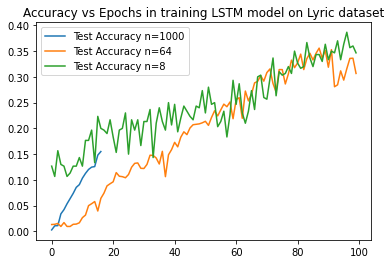

In [32]:
# Plot effect of changing number of artists trained on
with open('drive/MyDrive/NLU Project/evaluation-lists/LyricsLSTMTestList', 'rb') as file:
     lstmTestList = pickle.load(file)

with open('drive/MyDrive/NLU Project/evaluation-lists/LyricsLSTMTestListAs64', 'rb') as file:
     lstmTestList64 = pickle.load(file)

with open('drive/MyDrive/NLU Project/evaluation-lists/LyricsLSTMTestListAs8', 'rb') as file:
     lstmTestList8 = pickle.load(file)

#Plot training outputs on each model
epochRange1 = np.arange(len(lstmTestList))
epochRange2 = np.arange(len(lstmTestList64))
epochRange3 = np.arange(len(lstmTestList8))

plt.plot(epochRange1, lstmTestList, label = "Test Accuracy n=1000")

plt.plot(epochRange2, lstmTestList64, label = "Test Accuracy n=64")

plt.plot(epochRange3, lstmTestList8, label = "Test Accuracy n=8")

plt.title("Accuracy vs Epochs in training LSTM model on Lyric dataset")
plt.legend()
plt.show()


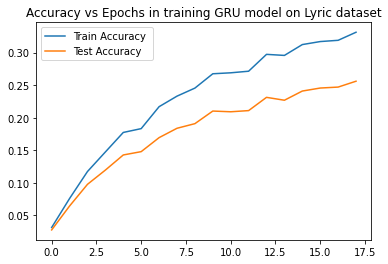

In [25]:
#load the lists generated during evaluation GRU
with open('drive/MyDrive/NLU Project/evaluation-lists/LyricsGRUTrainList', 'rb') as file:
     gruTrainList = pickle.load(file)
with open('drive/MyDrive/NLU Project/evaluation-lists/LyricsGRUTestList', 'rb') as file:
     gruTestList = pickle.load(file)
#Plot training outputs on each model
epochRange = np.arange(len(gruTrainList))
plt.plot(epochRange, gruTrainList, label = "Train Accuracy ")
plt.plot(epochRange, gruTestList, label = "Test Accuracy ")
plt.title("Accuracy vs Epochs in training GRU model on Lyric dataset")
plt.legend()
plt.show()


In [26]:
# Compare 3 artists and cluster them into 2 clusters
test_dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
model.eval()
model_output = []

artist1_name = "The Rolling Stones"
artist2_name = "The Beatles"
artist3_name = "Maroon 5"

artist1 = dataset.df.index[dataset.df['artist']== artist1_name].tolist()
artist2 = dataset.df.index[dataset.df['artist']== artist2_name].tolist()
artist3 = dataset.df.index[dataset.df['artist']== artist3_name].tolist()

for i, data in enumerate(test_dataloader):
  if i in artist1:
    modelOutputOnSampleBatch = model(data['input'])
    model_output += modelOutputOnSampleBatch.tolist()
    classPredictions = np.argmax(modelOutputOnSampleBatch.detach().numpy(), axis=1)
    
for i, data in enumerate(test_dataloader):
  if i in artist2:
    modelOutputOnSampleBatch = model(data['input'])
    model_output += modelOutputOnSampleBatch.tolist()
    classPredictions = np.argmax(modelOutputOnSampleBatch.detach().numpy(), axis=1)


for i, data in enumerate(test_dataloader):
  if i in artist3:
    modelOutputOnSampleBatch = model(data['input'])
    model_output += modelOutputOnSampleBatch.tolist()
    classPredictions = np.argmax(modelOutputOnSampleBatch.detach().numpy(), axis=1)
  

X = np.array(model_output)


kmeans = KMeans(n_clusters=2, random_state=None).fit(X)
kmeans.labels_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


array([0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1],
      dtype=int32)

In [27]:
# Normalize to use cosine distance
kmeans = KMeans(n_clusters=2, random_state=None).fit(preprocessing.normalize(X))
print()
print("Artist 1,", artist1_name, ": ", kmeans.labels_[:len(artist1)])
artist1_mean = np.mean(kmeans.labels_[:len(artist1)])
print("Mean Value:", artist1_mean)
print()
print("Artist 2,", artist2_name, ": ", kmeans.labels_[len(artist1):len(artist1) + len(artist2)])
artist2_mean = np.mean(kmeans.labels_[len(artist1):len(artist1) + len(artist2)])
print("Mean Value:", artist2_mean)
print()
print("Artist 3,", artist3_name, ": ", kmeans.labels_[len(artist1) + len(artist2) : len(artist1) + len(artist2) + len(artist3)])
artist3_mean = np.mean(kmeans.labels_[len(artist1) + len(artist2) : len(artist1) + len(artist2) + len(artist3)])
print("Mean Value:", artist3_mean)
print()
print("SIMILARITY ARTIST 1 and ARTIST 2:", 1-abs(artist1_mean - artist2_mean))
print("SIMILARITY ARTIST 1 and ARTIST 3:", 1-abs(artist1_mean - artist3_mean))
print("SIMILARITY ARTIST 2 and ARTIST 3:", 1-abs(artist2_mean - artist3_mean))
print()
kmeans.labels_



Artist 1, The Rolling Stones :  [1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 0 1 1 0 0 0 1 1 1 1]
Mean Value: 0.75

Artist 2, The Beatles :  [1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Mean Value: 0.9629629629629629

Artist 3, Maroon 5 :  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0]
Mean Value: 0.025

SIMILARITY ARTIST 1 and ARTIST 2: 0.7870370370370371
SIMILARITY ARTIST 1 and ARTIST 3: 0.275
SIMILARITY ARTIST 2 and ARTIST 3: 0.06203703703703711



array([1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
      dtype=int32)

In [28]:
# Show list of artists not used to train the model
unseen_artists.df.artist.unique()

array(['Judy Welden', 'The Browns', 'DJ Clue?', 'L7', 'Hawk Nelson',
       'GZA', 'Brian Setzer', 'Johnnie Taylor', 'Ane Brun',
       'Michael Nesmith', 'Billy Walker', 'The Early November',
       'Roger Williams', 'Ten Foot Pole', 'Tom Cochrane',
       'Days of the New', 'dc Talk', 'White Lion', 'Metal Church',
       'Method Man', 'Christopher Cross', 'Wilson Phillips', 'Delain',
       'The Coup', 'Ann-Margret', 'Shiny Toy Guns', 'Shivaree',
       'Eleni Mandell', 'Eli Young Band', 'The Blind Boys of Alabama',
       'The Blues Brothers', 'The Bluetones', 'The Cure', 'Faith No More',
       'Falconer', 'Fats Waller', 'Alexisonfire', 'Al Hirt',
       'Band of Horses', 'Kirsty MacColl', 'The Magic Numbers',
       'Emile Pandolfi', 'The New Amsterdams', 'Kevin Ayers',
       'Damian "Junior Gong" Marley', 'Beatsteaks', 'Natalie Imbruglia',
       'Natasha Bedingfield', 'Patti Austin', 'Daryl Hall',
       'Atomic Kitten', 'The Ataris', 'The Bird and the Bee',
       'We the King

In [29]:
# Evaluate a random 8000 songs from testing set
test_dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

model_output = []
randomlist = random.sample(range(0, len(dataset.df['artist'])), 8000)

    
for i, data in enumerate(test_dataloader):
  if i in randomlist:
    modelOutputOnSampleBatch = model(data['input'])
    model_output += modelOutputOnSampleBatch.tolist()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


KeyboardInterrupt: ignored

In [ ]:
# Evaluate all songs from an artist not used in model training 
unseen_artist_name = "The Cure"
unseen_artist_output = []
unseen_artist_idx = unseen_artists.df.index[unseen_artists.df['artist']== unseen_artist_name].tolist()
unseen_artist_dataloader = DataLoader(unseen_artists, batch_size=1, shuffle=False)

for i, data in enumerate(unseen_artist_dataloader):
  if i in unseen_artist_idx:
    modelOutputOnSampleBatch = model(data['input'])
    unseen_artist_output += modelOutputOnSampleBatch.tolist()
    classPredictions = np.argmax(modelOutputOnSampleBatch.detach().numpy(), axis=1)

# Get mean model output for all of the unseen artists songs
mean_vector = np.mean(unseen_artist_output, axis=0)

In [ ]:
# Create tree for evaluating closest vectors
tree = spatial.KDTree(preprocessing.normalize(model_output))

In [ ]:
# Normalise the vector to use cosine distance
normalised_mean_vector = preprocessing.normalize(mean_vector.reshape(1, -1))

# Query the tree to find the 30 closest songs
closest_30_songs = tree.query(normalised_mean_vector, k=30)[1]

In [ ]:
for index in closest_30_songs:
  print(dataset.df['artist'].loc[index])
  print(dataset.df['lyric'].loc[index])